#### Update content of the CPM Atlas - generate maps for past performance page<br>
Author          : Team BETA<br>
Return Values   : png files<br>
Source data     : The data is preprocessed and provided by Petter Lind.

In [1]:
import numpy as np
import xarray as xr
from pathlib import Path
from itertools import product
# regridding
import xesmf as xe
# plotting
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as crs
from cartopy import feature as cfeature
from textwrap import wrap
# for clipping
import rioxarray

In [2]:
# path to observation datasets
path_data = "/mnt/d/NLeSC/BETA/EUCP/Data_Catalogue/data_Petter_Lind"

In [3]:
# alias of regions
regions_name_dict = {
  "nwe-3": "NW",
  "swe-3": "SW",
  "see-3": "SE",
  "ceu-3": "C",
  "cee-3": "CE",
  "neu-3": "N",
  "alp-3": "AL",
}

# define geometries for clipping by regions
regions = {
  "NW": [
    {
      'type': 'Polygon',
      'coordinates': [[[-8.0, 40.4], [11.0, 40.4], [15.2, 58.6], [-12.5, 58.6], [-8.0, 40.4]]]
    }
  ],
  "SW": [
    {
      'type': 'Polygon',
      'coordinates': [[[-10, 30], [7.4, 33], [5.7, 48.9], [-15, 45.4], [-10, 30]]]
    }
  ],
  "SE": [
    {
      'type': 'Polygon',
      'coordinates': [[[12.5, 34.3], [28.5, 34.3], [29.4, 40.9], [11.5, 40.9], [12.5, 34.3]]]
    }
  ],
  "C": [
    {
      'type': 'Polygon',
      'coordinates': [[[5.0, 44.5], [18.0, 45.5], [18.0, 56.0], [1.0, 53.0], [5.0, 44.5]]]
    }
  ],
  "CE": [
    {
      'type': 'Polygon',
      'coordinates': [[[17.8, 41.5], [31.3, 41.5], [32.8, 51.6], [16.4, 51.6], [17.8, 41.5]]]
    }
  ],
  "N": [
    {
      'type': 'Polygon',
      'coordinates': [[[1, 50.7], [26.7, 49.7], [44.1, 70.6], [-9.4, 72.6], [1, 50.7]]]
    }
  ],
  "AL": [
    {
      'type': 'Polygon',
      'coordinates': [[[1, 40], [17, 40], [17, 50], [1, 50], [1, 40]]]
    }
  ]
}

In [4]:
def diff_obs_model(infile, variable):
    """Compute the difference between observation and model outputs.
    """
    # load the input data
    model_data = xr.open_dataset(infile)
    # get the correct observation data
    if variable == "pr":
        obs_data = xr.open_dataset(Path(path_data, "OBS", "EOBS20_seasonal_cycle_pr_day_mean_native_grid_1980-2010_ANN.nc"))
    elif variable == "tas":
        obs_data = xr.open_dataset(Path(path_data, "OBS", "EOBS20_seasonal_cycle_tas_day_mean_native_grid_1980-2010_ANN.nc"))
    #############################################################
    ### regridding from model native grid to observation grid ###
    #############################################################
    # mask input data and observation data
    # note that the mask is the same for all seasons
    model_data['mask'] = xr.where(~np.isnan(model_data[f"{variable}"].sel(season="DJF")), 1, 0)
    obs_data['mask'] = xr.where(~np.isnan(obs_data[f"{variable}"].sel(season="DJF")), 1, 0)
    # create regridder
    regridder = xe.Regridder(model_data, obs_data, "bilinear")
    # use the regridder to regrid data
    model_data_regrid = regridder(model_data[f"{variable}"])
    ###############################################################
    ### compute difference between model output and observation ###
    ###############################################################
    diff_data = model_data_regrid - obs_data[f"{variable}"]

    return diff_data

In [5]:
def region_clip(input_data, region):
    # change filled values to 0, to avoid errors after clipping
    # input_data[f"{variable}"] = input_data[f"{variable}"].where(input_data[f"{variable}"]<1e+10, 0)
    # drop unused variables, otherwise it will cause 
    # an error when configuring the coordinate system
    # input_data = input_data.drop_vars("rlat")
    # input_data = input_data.drop_vars("rlon")
    # set-up the coordinate system known to rio
    input_data.rio.write_crs("EPSG:4326", inplace=True)
    # clip data
    clipped_data = input_data.rio.clip(regions[region], "EPSG:4326", all_touched=True)

    return clipped_data

In [6]:
# function for plotting maps
def plot_map(dataset, outfile, model, season, region, variable):
    # Plot
    fig = plt.figure(dpi=120)
    ax = fig.add_subplot(111, projection=crs.PlateCarree())
    if variable == "pr":
        levels = np.arange(-10, 11, 1)
        dataset.sel(season=f"{season}").plot(ax=ax, levels=levels, cmap="BrBG",
                                        cbar_kwargs={'label': 'Precipitation difference (mm)',
                                        'extend': 'neither'})
    elif variable == "tas":
        levels = np.arange(-10, 11, 1)
        dataset.sel(season=f"{season}").plot(ax=ax, levels=levels, cmap="YlOrRd",
                                        cbar_kwargs={'label': 'Temperature difference (degC)',
                                        'extend': 'neither'})
    # colorbar
    # cbar = fig.colorbar(im)
    # cbar.set_label('')
    # Prettify
    ax.add_feature(cfeature.OCEAN, zorder=2)
    ax.coastlines(zorder=3)
    ax.axis('off')
    if variable == "pr":
        ax.set_title("\n".join(wrap(f'{model} | {season} | {region}', 30)))
    elif variable == "tas":
        ax.set_title("\n".join(wrap(f'{model} | {season} | {region}', 30)))

    # Save
    fig.savefig(outfile)
    plt.close()

Processed /mnt/d/NLeSC/BETA/EUCP/Data_Catalogue/data_Petter_Lind/CPM/tas/alp-3_cclm_ec-earth_his_seasonal_cycle_tas_D_mean_mean_native_grid_1996-2005_ANN.nc, created ../static/cpm_analysis/past_performance/AL/tas/cclm_ec-earth_DJF.png.
Processed /mnt/d/NLeSC/BETA/EUCP/Data_Catalogue/data_Petter_Lind/CPM/tas/alp-3_cclm_ec-earth_his_seasonal_cycle_tas_D_mean_mean_native_grid_1996-2005_ANN.nc, created ../static/cpm_analysis/past_performance/AL/tas/cclm_ec-earth_JJA.png.
Processed /mnt/d/NLeSC/BETA/EUCP/Data_Catalogue/data_Petter_Lind/CPM/tas/alp-3_cnrm-arome_cnrm-cm5_his_seasonal_cycle_tas_D_mean_mean_native_grid_1996-2005_ANN.nc, created ../static/cpm_analysis/past_performance/AL/tas/cnrm-arome_cnrm-cm5_DJF.png.
Processed /mnt/d/NLeSC/BETA/EUCP/Data_Catalogue/data_Petter_Lind/CPM/tas/alp-3_cnrm-arome_cnrm-cm5_his_seasonal_cycle_tas_D_mean_mean_native_grid_1996-2005_ANN.nc, created ../static/cpm_analysis/past_performance/AL/tas/cnrm-arome_cnrm-cm5_JJA.png.
Processed /mnt/d/NLeSC/BETA/EUCP

FileNotFoundError: [Errno 2] No such file or directory: '../static/cpm_analysis/past_performance/SW/tas/ethz-cclm_ecmwf-erai_DJF.png'

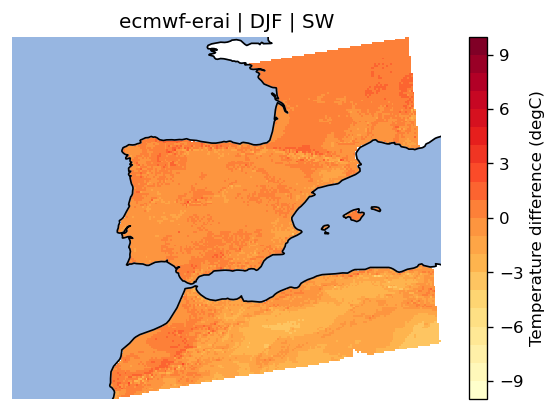

In [7]:
# load all relevant datasets and plot maps
seasons = ['DJF', 'JJA']
variables = ['tas', 'pr']
#projects = ["CPM", "RCM", "GCM"]
projects = ["CPM", "RCM"]

for project, variable in product(projects, variables):
    directory = path_data + f"/{project}/{variable}"
    for ncfile in Path(directory).iterdir():
        # filter the historical runs
        if "his" in str(ncfile):
            if project == "GCM":
                region, group, model, _ = ncfile.stem.split('_')[:3]
            else:
                region, group, model = ncfile.stem.split('_')[:3]
                if region == "reu-3": # reu-3 covers all the sub-regions
                    diff_data = diff_obs_model(ncfile, variable)
                    for region_alias in regions.keys():
                        clipped_region = region_clip(diff_data, region_alias)
                        for season in seasons:
                            outfile = (f"../static/cpm_analysis/past_performance/{region_alias}/{variable}/{group}_{model}_{season}.png")
                            plot_map(clipped_region, outfile, model,
                             season, region_alias, variable)
                            print(f"Processed {ncfile}, created {outfile}.")
                else: # other regions correspond to single sub-region
                    region_alias = regions_name_dict[f"{region}"]
                    diff_data = diff_obs_model(ncfile, variable)
                    clipped_region = region_clip(diff_data, region_alias)
                    for season in seasons:
                        outfile = (f"../static/cpm_analysis/past_performance/{region_alias}/{variable}/{group}_{model}_{season}.png")
                        plot_map(clipped_region, outfile, model,
                         season, region_alias, variable)
                        print(f"Processed {ncfile}, created {outfile}.")